In [1]:
# Importing necessary libraries, python files containing functions to create model, fetch data
import torch
torch.manual_seed(17)

import numpy as np
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

from DataCollector import DataCollector
from resnet_model import *

In [2]:
# Check available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Fetching Dataset
df = DataCollector(dataset="CIFAR10", batch_size=128)
df.add_Horizontal_Flip()
df.add_Random_Crop(size=32, padding=4)
df.add_Normalizer()
trainLoader, testLoader = df.fetch_Loaders()

Initializing fetching CIFAR10 dataset using torchvision


100%|██████████| 170498071/170498071 [00:02<00:00, 67387710.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Get Model
model = resnet_model()
model = model.to(device)
print(summary(model, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,248
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,248
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,248
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,248
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,496
      BatchNorm2d-14           [-1, 64,

In [ ]:
# Setting up training
EPOCHS=250
globalBestAccuracy = 0.0
training_loss = []
testing_loss = []
training_accuracy = []
testing_accuracy = []

In [ ]:
# Defining Loss Function, Learning Rate, Weight Decay, Optimizer) 
lossFunction = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.01
weightDecay = 0.0001

optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)

print(model.eval())

trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters : %s"%(trainable_parameters))

if trainable_parameters > 5*(10**6):
    raise Exception("Model not under budget!")

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential

In [ ]:
# Training
for i in tqdm(range(EPOCHS)):
    
    for phase in ['train', 'test']:
        if phase == "train":
            loader = trainLoader
            model.train()
            optimizer.zero_grad()
        else:
            loader = testLoader
            model.eval()

        cumulativeLoss = 0.0
        cumulativeCorrects = 0
        
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = lossFunction(output, labels)
            predicted_labels = torch.argmax(output, dim=1)
            #cumulativeLoss += loss.item()*images.size(0)
            cumulativeLoss += loss.item()
            cumulativeCorrects += torch.sum(predicted_labels == labels).float().item()
            if phase == "train":
                loss.backward()
                optimizer.step()
        
        epoch_loss = cumulativeLoss/len(loader.dataset)
        epoch_accuracy = cumulativeCorrects/len(loader.dataset)
        if phase == "train":
            scheduler.step()
            training_loss.append(epoch_loss)
            training_accuracy.append(epoch_accuracy)
        else:
            testing_loss.append(epoch_loss)
            testing_accuracy.append(epoch_accuracy)
            if epoch_accuracy > globalBestAccuracy:
                globalBestAccuracy = epoch_accuracy
                model.saveToDisk()

    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(training_loss[-1], testing_loss[-1], training_accuracy[-1], testing_accuracy[-1]))

  0%|          | 1/250 [00:26<1:51:51, 26.95s/it]

Training Loss : 1.6343954931640625, Testing Loss : 1.5071948650360107, Training Accuracy : 0.3902, Testing Accuracy : 0.4609


  1%|          | 2/250 [00:53<1:50:39, 26.77s/it]

Training Loss : 1.394906949005127, Testing Loss : 1.2838241411209106, Training Accuracy : 0.49046, Testing Accuracy : 0.5334


  1%|          | 3/250 [01:19<1:49:27, 26.59s/it]

Training Loss : 1.2204452990722656, Testing Loss : 1.1571331296920777, Training Accuracy : 0.55888, Testing Accuracy : 0.5883


  2%|▏         | 4/250 [01:46<1:48:16, 26.41s/it]

Training Loss : 1.0867668423461914, Testing Loss : 1.0372467853546143, Training Accuracy : 0.61158, Testing Accuracy : 0.6285


  2%|▏         | 5/250 [02:12<1:47:29, 26.32s/it]

Training Loss : 0.979094700012207, Testing Loss : 1.0137272743225099, Training Accuracy : 0.6519, Testing Accuracy : 0.6439


  2%|▏         | 6/250 [02:38<1:46:47, 26.26s/it]

Training Loss : 0.8955542794799805, Testing Loss : 0.953379204750061, Training Accuracy : 0.68214, Testing Accuracy : 0.6725


  3%|▎         | 7/250 [03:04<1:46:11, 26.22s/it]

Training Loss : 0.8183156617736816, Testing Loss : 0.7955819082260132, Training Accuracy : 0.71214, Testing Accuracy : 0.7243


  3%|▎         | 8/250 [03:31<1:46:03, 26.30s/it]

Training Loss : 0.7507552093505859, Testing Loss : 0.7481962648391723, Training Accuracy : 0.73348, Testing Accuracy : 0.7401


  4%|▎         | 9/250 [03:57<1:45:26, 26.25s/it]

Training Loss : 0.6909528308105469, Testing Loss : 0.7556544931411743, Training Accuracy : 0.7571, Testing Accuracy : 0.7414


  4%|▍         | 10/250 [04:23<1:44:54, 26.23s/it]

Training Loss : 0.6492873732757568, Testing Loss : 0.6918235632896423, Training Accuracy : 0.77452, Testing Accuracy : 0.764


  4%|▍         | 11/250 [04:49<1:44:58, 26.35s/it]

Training Loss : 0.6063681935882569, Testing Loss : 0.656234429359436, Training Accuracy : 0.78986, Testing Accuracy : 0.7758


  5%|▍         | 12/250 [05:17<1:45:22, 26.56s/it]

Training Loss : 0.5698451664733887, Testing Loss : 0.6516445344924927, Training Accuracy : 0.80314, Testing Accuracy : 0.7814


  5%|▌         | 13/250 [05:43<1:44:53, 26.55s/it]

Training Loss : 0.5434609471130372, Testing Loss : 0.6006057459831238, Training Accuracy : 0.8122, Testing Accuracy : 0.7975


  6%|▌         | 14/250 [06:09<1:44:17, 26.51s/it]

Training Loss : 0.5191209704589844, Testing Loss : 0.5716585751056671, Training Accuracy : 0.82028, Testing Accuracy : 0.8061


  6%|▌         | 15/250 [06:36<1:43:44, 26.49s/it]

Training Loss : 0.4877896686553955, Testing Loss : 0.5705804065227509, Training Accuracy : 0.83212, Testing Accuracy : 0.8068


  6%|▋         | 16/250 [07:02<1:43:07, 26.44s/it]

Training Loss : 0.46701219650268555, Testing Loss : 0.5985832470178604, Training Accuracy : 0.83908, Testing Accuracy : 0.7976


  7%|▋         | 17/250 [07:28<1:42:25, 26.38s/it]

Training Loss : 0.44889122482299804, Testing Loss : 0.5340766809463501, Training Accuracy : 0.8454, Testing Accuracy : 0.822


  7%|▋         | 18/250 [07:55<1:41:58, 26.37s/it]

Training Loss : 0.4206232004547119, Testing Loss : 0.5178154188156128, Training Accuracy : 0.85384, Testing Accuracy : 0.8265


  8%|▊         | 19/250 [08:21<1:41:39, 26.40s/it]

Training Loss : 0.41326026889801026, Testing Loss : 0.5389543008804322, Training Accuracy : 0.85612, Testing Accuracy : 0.8239


  8%|▊         | 20/250 [08:48<1:41:03, 26.36s/it]

Training Loss : 0.3887335678100586, Testing Loss : 0.4939839255332947, Training Accuracy : 0.86792, Testing Accuracy : 0.8369


  8%|▊         | 21/250 [09:14<1:40:13, 26.26s/it]

Training Loss : 0.38479137409210207, Testing Loss : 0.5136829566955566, Training Accuracy : 0.86842, Testing Accuracy : 0.8327


  9%|▉         | 22/250 [09:40<1:39:53, 26.29s/it]

Training Loss : 0.3731544202041626, Testing Loss : 0.5222257334232331, Training Accuracy : 0.87004, Testing Accuracy : 0.8392


  9%|▉         | 23/250 [10:06<1:39:15, 26.24s/it]

Training Loss : 0.348143218460083, Testing Loss : 0.47700057249069217, Training Accuracy : 0.8785, Testing Accuracy : 0.84


 10%|▉         | 24/250 [10:32<1:39:02, 26.29s/it]

Training Loss : 0.34026196880340576, Testing Loss : 0.52162323346138, Training Accuracy : 0.88134, Testing Accuracy : 0.8366


 10%|█         | 25/250 [10:59<1:38:50, 26.36s/it]

Training Loss : 0.334897469367981, Testing Loss : 0.4712444313764572, Training Accuracy : 0.88424, Testing Accuracy : 0.8526


 10%|█         | 26/250 [11:26<1:39:35, 26.68s/it]

Training Loss : 0.3113419673156738, Testing Loss : 0.48388034071922303, Training Accuracy : 0.893, Testing Accuracy : 0.8491


 11%|█         | 27/250 [11:53<1:38:46, 26.58s/it]

Training Loss : 0.30265151416778563, Testing Loss : 0.4511756063938141, Training Accuracy : 0.89478, Testing Accuracy : 0.8543


 11%|█         | 28/250 [12:19<1:38:19, 26.58s/it]

Training Loss : 0.29263883750915526, Testing Loss : 0.4408838900566101, Training Accuracy : 0.89862, Testing Accuracy : 0.8608


 12%|█▏        | 29/250 [12:46<1:37:44, 26.54s/it]

Training Loss : 0.2751239612960815, Testing Loss : 0.44088646718263624, Training Accuracy : 0.90504, Testing Accuracy : 0.8558


 12%|█▏        | 30/250 [13:12<1:36:59, 26.45s/it]

Training Loss : 0.2666829092025757, Testing Loss : 0.43659285025596617, Training Accuracy : 0.90766, Testing Accuracy : 0.8637


 12%|█▏        | 31/250 [13:39<1:36:52, 26.54s/it]

Training Loss : 0.2565793005561829, Testing Loss : 0.4357432878732681, Training Accuracy : 0.91102, Testing Accuracy : 0.8647


 13%|█▎        | 32/250 [14:05<1:36:05, 26.45s/it]

Training Loss : 0.24966817457199098, Testing Loss : 0.4289446248054504, Training Accuracy : 0.91282, Testing Accuracy : 0.868


 13%|█▎        | 33/250 [14:31<1:35:38, 26.45s/it]

Training Loss : 0.23944040491104127, Testing Loss : 0.442109489440918, Training Accuracy : 0.91702, Testing Accuracy : 0.8685


 14%|█▎        | 34/250 [14:58<1:35:06, 26.42s/it]

Training Loss : 0.24076389335632326, Testing Loss : 0.45745682678222654, Training Accuracy : 0.91502, Testing Accuracy : 0.8623


 14%|█▍        | 35/250 [15:25<1:35:01, 26.52s/it]

Training Loss : 0.22685432744979858, Testing Loss : 0.42198284845352174, Training Accuracy : 0.9192, Testing Accuracy : 0.871


 14%|█▍        | 36/250 [15:51<1:34:31, 26.50s/it]

Training Loss : 0.2165857246208191, Testing Loss : 0.4431907742500305, Training Accuracy : 0.92386, Testing Accuracy : 0.8689


 15%|█▍        | 37/250 [16:18<1:34:24, 26.60s/it]

Training Loss : 0.21392579798698425, Testing Loss : 0.4226348881244659, Training Accuracy : 0.92644, Testing Accuracy : 0.8748


 15%|█▌        | 38/250 [16:45<1:34:19, 26.70s/it]

Training Loss : 0.2026744201850891, Testing Loss : 0.42560243883132937, Training Accuracy : 0.92916, Testing Accuracy : 0.8733


 16%|█▌        | 39/250 [17:11<1:33:17, 26.53s/it]

Training Loss : 0.1877232738685608, Testing Loss : 0.4478964609146118, Training Accuracy : 0.93348, Testing Accuracy : 0.8734


 16%|█▌        | 40/250 [17:37<1:32:35, 26.46s/it]

Training Loss : 0.19698917690277098, Testing Loss : 0.3900730357646942, Training Accuracy : 0.9307, Testing Accuracy : 0.8803


 16%|█▋        | 41/250 [18:03<1:31:40, 26.32s/it]

Training Loss : 0.183149065284729, Testing Loss : 0.4403972345352173, Training Accuracy : 0.93652, Testing Accuracy : 0.8775


 17%|█▋        | 42/250 [18:29<1:31:09, 26.29s/it]

Training Loss : 0.17381861760139466, Testing Loss : 0.39415535383224487, Training Accuracy : 0.93854, Testing Accuracy : 0.8844


 17%|█▋        | 43/250 [18:55<1:30:18, 26.17s/it]

Training Loss : 0.1703815559387207, Testing Loss : 0.44477710809707643, Training Accuracy : 0.94052, Testing Accuracy : 0.8825


 18%|█▊        | 44/250 [19:22<1:30:07, 26.25s/it]

Training Loss : 0.1789003909301758, Testing Loss : 0.4403520536422729, Training Accuracy : 0.93648, Testing Accuracy : 0.8707


 18%|█▊        | 45/250 [19:48<1:29:28, 26.19s/it]

Training Loss : 0.17315269773483277, Testing Loss : 0.4515843379020691, Training Accuracy : 0.94072, Testing Accuracy : 0.8758


 18%|█▊        | 46/250 [20:14<1:28:58, 26.17s/it]

Training Loss : 0.16835560401916505, Testing Loss : 0.46125401191711424, Training Accuracy : 0.94076, Testing Accuracy : 0.8746


 19%|█▉        | 47/250 [20:40<1:28:38, 26.20s/it]

Training Loss : 0.1616192529773712, Testing Loss : 0.4068812072753906, Training Accuracy : 0.94286, Testing Accuracy : 0.8889


 19%|█▉        | 48/250 [21:06<1:28:08, 26.18s/it]

Training Loss : 0.15365872357368468, Testing Loss : 0.4166880269050598, Training Accuracy : 0.9468, Testing Accuracy : 0.8845


 20%|█▉        | 49/250 [21:33<1:27:47, 26.21s/it]

Training Loss : 0.15489691878318787, Testing Loss : 0.4431747389316559, Training Accuracy : 0.9443, Testing Accuracy : 0.8778


 20%|██        | 50/250 [21:59<1:27:36, 26.28s/it]

Training Loss : 0.15679681832313538, Testing Loss : 0.39936832456588744, Training Accuracy : 0.94442, Testing Accuracy : 0.8875


 20%|██        | 51/250 [22:26<1:28:10, 26.59s/it]

Training Loss : 0.14127906467437745, Testing Loss : 0.41882042064666747, Training Accuracy : 0.9499, Testing Accuracy : 0.8877


 21%|██        | 52/250 [22:53<1:27:35, 26.54s/it]

Training Loss : 0.1340232985162735, Testing Loss : 0.4332393571376801, Training Accuracy : 0.95192, Testing Accuracy : 0.8862


 21%|██        | 53/250 [23:19<1:26:50, 26.45s/it]

Training Loss : 0.1356624837589264, Testing Loss : 0.41012445244789125, Training Accuracy : 0.95138, Testing Accuracy : 0.8899


 22%|██▏       | 54/250 [23:45<1:25:56, 26.31s/it]

Training Loss : 0.12428897643089294, Testing Loss : 0.4340195114910603, Training Accuracy : 0.95546, Testing Accuracy : 0.8881


 22%|██▏       | 55/250 [24:11<1:25:08, 26.20s/it]

Training Loss : 0.12601755183696747, Testing Loss : 0.42691469049453734, Training Accuracy : 0.9542, Testing Accuracy : 0.8865


 22%|██▏       | 56/250 [24:37<1:24:44, 26.21s/it]

Training Loss : 0.12237428302764893, Testing Loss : 0.4066264795064926, Training Accuracy : 0.95668, Testing Accuracy : 0.8955


 23%|██▎       | 57/250 [25:03<1:24:09, 26.16s/it]

Training Loss : 0.11213422257423401, Testing Loss : 0.43573206043243407, Training Accuracy : 0.96088, Testing Accuracy : 0.8861


 23%|██▎       | 58/250 [25:29<1:23:41, 26.16s/it]

Training Loss : 0.11525843062400817, Testing Loss : 0.43622570276260375, Training Accuracy : 0.95868, Testing Accuracy : 0.885


 24%|██▎       | 59/250 [25:55<1:23:08, 26.12s/it]

Training Loss : 0.1187697146654129, Testing Loss : 0.4198424454689026, Training Accuracy : 0.95868, Testing Accuracy : 0.8907


 24%|██▍       | 60/250 [26:22<1:22:44, 26.13s/it]

Training Loss : 0.11209432513237, Testing Loss : 0.4388472187042236, Training Accuracy : 0.96104, Testing Accuracy : 0.8892


 24%|██▍       | 61/250 [26:47<1:22:00, 26.03s/it]

Training Loss : 0.10836361922740936, Testing Loss : 0.4098141939163208, Training Accuracy : 0.96192, Testing Accuracy : 0.8942


 25%|██▍       | 62/250 [27:13<1:21:37, 26.05s/it]

Training Loss : 0.10475564663410186, Testing Loss : 0.43009226665496825, Training Accuracy : 0.96224, Testing Accuracy : 0.8918


 25%|██▌       | 63/250 [27:40<1:21:15, 26.07s/it]

Training Loss : 0.10216123262405395, Testing Loss : 0.4346220595359802, Training Accuracy : 0.96352, Testing Accuracy : 0.8895


 26%|██▌       | 64/250 [28:06<1:20:51, 26.08s/it]

Training Loss : 0.09954947328567505, Testing Loss : 0.4166541929244995, Training Accuracy : 0.9648, Testing Accuracy : 0.8927


 26%|██▌       | 65/250 [28:32<1:21:02, 26.28s/it]

Training Loss : 0.09461515788078308, Testing Loss : 0.4507294005393982, Training Accuracy : 0.96678, Testing Accuracy : 0.8892


 26%|██▋       | 66/250 [28:59<1:21:01, 26.42s/it]

Training Loss : 0.09336331071853637, Testing Loss : 0.4208820159435272, Training Accuracy : 0.9673, Testing Accuracy : 0.8949


 27%|██▋       | 67/250 [29:25<1:20:22, 26.35s/it]

Training Loss : 0.0903275187587738, Testing Loss : 0.45395920963287356, Training Accuracy : 0.96814, Testing Accuracy : 0.8941


 27%|██▋       | 68/250 [29:52<1:19:52, 26.33s/it]

Training Loss : 0.09134669153690338, Testing Loss : 0.45442554006576535, Training Accuracy : 0.96722, Testing Accuracy : 0.8951


 28%|██▊       | 69/250 [30:18<1:19:25, 26.33s/it]

Training Loss : 0.08901996398210525, Testing Loss : 0.4355063241481781, Training Accuracy : 0.96858, Testing Accuracy : 0.8961


 28%|██▊       | 70/250 [30:44<1:18:56, 26.31s/it]

Training Loss : 0.08106385755181313, Testing Loss : 0.4764093315124512, Training Accuracy : 0.971, Testing Accuracy : 0.8979


 28%|██▊       | 71/250 [31:10<1:18:16, 26.24s/it]

Training Loss : 0.08342899691820145, Testing Loss : 0.45294934368133544, Training Accuracy : 0.96952, Testing Accuracy : 0.8982


 29%|██▉       | 72/250 [31:37<1:17:49, 26.23s/it]

Training Loss : 0.0821457307100296, Testing Loss : 0.44945913887023925, Training Accuracy : 0.97058, Testing Accuracy : 0.8948


 29%|██▉       | 73/250 [32:03<1:17:27, 26.26s/it]

Training Loss : 0.0781340098786354, Testing Loss : 0.43144817190170287, Training Accuracy : 0.97236, Testing Accuracy : 0.9013


 30%|██▉       | 74/250 [32:29<1:16:54, 26.22s/it]

Training Loss : 0.07736555827617646, Testing Loss : 0.4683075974464416, Training Accuracy : 0.97278, Testing Accuracy : 0.896


 30%|███       | 75/250 [32:55<1:16:18, 26.16s/it]

Training Loss : 0.07979188188791275, Testing Loss : 0.43560219473838807, Training Accuracy : 0.97254, Testing Accuracy : 0.8989


 30%|███       | 76/250 [33:21<1:16:00, 26.21s/it]

Training Loss : 0.07606762714385987, Testing Loss : 0.4595592794895172, Training Accuracy : 0.97256, Testing Accuracy : 0.8973


 31%|███       | 77/250 [33:47<1:15:23, 26.15s/it]

Training Loss : 0.07183491631031036, Testing Loss : 0.44245177536010744, Training Accuracy : 0.9736, Testing Accuracy : 0.899


 31%|███       | 78/250 [34:14<1:15:17, 26.26s/it]

Training Loss : 0.07387369405269623, Testing Loss : 0.4588366844177246, Training Accuracy : 0.97396, Testing Accuracy : 0.8966


 32%|███▏      | 79/250 [34:41<1:15:22, 26.44s/it]

Training Loss : 0.07539629937887192, Testing Loss : 0.44525185856223104, Training Accuracy : 0.97382, Testing Accuracy : 0.8964


 32%|███▏      | 80/250 [35:07<1:14:58, 26.46s/it]

Training Loss : 0.07371235411405563, Testing Loss : 0.45812556495666507, Training Accuracy : 0.97386, Testing Accuracy : 0.8963


 32%|███▏      | 81/250 [35:33<1:14:20, 26.40s/it]

Training Loss : 0.0667859283721447, Testing Loss : 0.4523424990653992, Training Accuracy : 0.97622, Testing Accuracy : 0.8954


 33%|███▎      | 82/250 [36:00<1:13:54, 26.39s/it]

Training Loss : 0.06129276865720749, Testing Loss : 0.4322467749595642, Training Accuracy : 0.97806, Testing Accuracy : 0.9025


 33%|███▎      | 83/250 [36:27<1:13:44, 26.49s/it]

Training Loss : 0.05349854268789291, Testing Loss : 0.48640268993377683, Training Accuracy : 0.981, Testing Accuracy : 0.895


 34%|███▎      | 84/250 [36:53<1:13:27, 26.55s/it]

Training Loss : 0.05506274640202522, Testing Loss : 0.46782908096313475, Training Accuracy : 0.98004, Testing Accuracy : 0.898


 34%|███▍      | 85/250 [37:20<1:13:11, 26.62s/it]

Training Loss : 0.06676549429059028, Testing Loss : 0.46197688455581665, Training Accuracy : 0.9758, Testing Accuracy : 0.9005


 34%|███▍      | 86/250 [37:46<1:12:31, 26.53s/it]

Training Loss : 0.054840729150772094, Testing Loss : 0.48088514828681944, Training Accuracy : 0.9798, Testing Accuracy : 0.8988


 35%|███▍      | 87/250 [38:13<1:12:06, 26.54s/it]

Training Loss : 0.05803458257436752, Testing Loss : 0.49646861686706545, Training Accuracy : 0.97968, Testing Accuracy : 0.8953


 35%|███▌      | 88/250 [38:40<1:11:53, 26.62s/it]

Training Loss : 0.05951947357296944, Testing Loss : 0.45601685218811033, Training Accuracy : 0.9789, Testing Accuracy : 0.8999


 36%|███▌      | 89/250 [39:07<1:11:46, 26.75s/it]

Training Loss : 0.05262975241422653, Testing Loss : 0.4573821949005127, Training Accuracy : 0.98128, Testing Accuracy : 0.9027


 36%|███▌      | 90/250 [39:34<1:11:45, 26.91s/it]

Training Loss : 0.053367903417348865, Testing Loss : 0.469827480173111, Training Accuracy : 0.98078, Testing Accuracy : 0.8984


 36%|███▋      | 91/250 [40:01<1:11:10, 26.86s/it]

Training Loss : 0.054755804349184034, Testing Loss : 0.4850583881318569, Training Accuracy : 0.9808, Testing Accuracy : 0.8997


 37%|███▋      | 92/250 [40:28<1:10:50, 26.90s/it]

Training Loss : 0.0539698591285944, Testing Loss : 0.47192015023231504, Training Accuracy : 0.98086, Testing Accuracy : 0.8996


 37%|███▋      | 93/250 [40:55<1:10:14, 26.84s/it]

Training Loss : 0.05070779743552208, Testing Loss : 0.4711536581993103, Training Accuracy : 0.98278, Testing Accuracy : 0.9031


 38%|███▊      | 94/250 [41:21<1:09:49, 26.86s/it]

Training Loss : 0.04607897702097893, Testing Loss : 0.4661076406478882, Training Accuracy : 0.98308, Testing Accuracy : 0.9004


 38%|███▊      | 95/250 [41:48<1:09:15, 26.81s/it]

Training Loss : 0.04519664008617401, Testing Loss : 0.49710816640853883, Training Accuracy : 0.98436, Testing Accuracy : 0.9002


 38%|███▊      | 96/250 [42:15<1:08:48, 26.81s/it]

Training Loss : 0.048242170112133026, Testing Loss : 0.48589528741836546, Training Accuracy : 0.98326, Testing Accuracy : 0.8987


 39%|███▉      | 97/250 [42:42<1:08:16, 26.77s/it]

Training Loss : 0.05216513409733772, Testing Loss : 0.5185856250286103, Training Accuracy : 0.98112, Testing Accuracy : 0.8946


 39%|███▉      | 98/250 [43:09<1:08:05, 26.88s/it]

Training Loss : 0.0531056238681078, Testing Loss : 0.480313320350647, Training Accuracy : 0.9808, Testing Accuracy : 0.9011


 40%|███▉      | 99/250 [43:36<1:07:58, 27.01s/it]

Training Loss : 0.04738528431236744, Testing Loss : 0.46776698975563047, Training Accuracy : 0.9835, Testing Accuracy : 0.9027


 40%|████      | 100/250 [44:03<1:07:11, 26.88s/it]

Training Loss : 0.04244494017422199, Testing Loss : 0.4796612728595734, Training Accuracy : 0.9853, Testing Accuracy : 0.9043


 40%|████      | 101/250 [44:29<1:06:32, 26.79s/it]

Training Loss : 0.04556053196310997, Testing Loss : 0.48460838193893435, Training Accuracy : 0.98396, Testing Accuracy : 0.9059


 41%|████      | 102/250 [44:56<1:05:55, 26.73s/it]

Training Loss : 0.0420001047116518, Testing Loss : 0.478641934299469, Training Accuracy : 0.98474, Testing Accuracy : 0.9024


 41%|████      | 103/250 [45:22<1:05:21, 26.68s/it]

Training Loss : 0.04228158715307712, Testing Loss : 0.4612583350658417, Training Accuracy : 0.98514, Testing Accuracy : 0.9074


 42%|████▏     | 104/250 [45:49<1:04:47, 26.63s/it]

Training Loss : 0.03838276831269264, Testing Loss : 0.476859317779541, Training Accuracy : 0.98674, Testing Accuracy : 0.9072


 42%|████▏     | 105/250 [46:16<1:04:21, 26.63s/it]

Training Loss : 0.03279564807534218, Testing Loss : 0.4942066423892975, Training Accuracy : 0.98856, Testing Accuracy : 0.9039


 42%|████▏     | 106/250 [46:42<1:03:58, 26.66s/it]

Training Loss : 0.039160889325737955, Testing Loss : 0.5002076343536377, Training Accuracy : 0.98596, Testing Accuracy : 0.9009


 43%|████▎     | 107/250 [47:09<1:03:33, 26.67s/it]

Training Loss : 0.04137405224621296, Testing Loss : 0.5008858125686646, Training Accuracy : 0.98528, Testing Accuracy : 0.9029


 43%|████▎     | 108/250 [47:36<1:03:41, 26.91s/it]

Training Loss : 0.043721552216410636, Testing Loss : 0.5612720534324646, Training Accuracy : 0.9849, Testing Accuracy : 0.898


 44%|████▎     | 109/250 [48:03<1:03:13, 26.90s/it]

Training Loss : 0.040141892352104185, Testing Loss : 0.5001935371398926, Training Accuracy : 0.98564, Testing Accuracy : 0.9026


 44%|████▍     | 110/250 [48:30<1:02:39, 26.85s/it]

Training Loss : 0.036003545140624045, Testing Loss : 0.49973123350143434, Training Accuracy : 0.98786, Testing Accuracy : 0.9073


 44%|████▍     | 111/250 [48:56<1:01:56, 26.73s/it]

Training Loss : 0.03328900190889835, Testing Loss : 0.48736636476516726, Training Accuracy : 0.98776, Testing Accuracy : 0.9049


 45%|████▍     | 112/250 [49:23<1:01:01, 26.54s/it]

Training Loss : 0.034152344036102296, Testing Loss : 0.49405503520965577, Training Accuracy : 0.98826, Testing Accuracy : 0.9081


 45%|████▌     | 113/250 [49:49<1:00:16, 26.40s/it]

Training Loss : 0.033810674628764394, Testing Loss : 0.4936459979534149, Training Accuracy : 0.9884, Testing Accuracy : 0.9072


 46%|████▌     | 114/250 [50:15<59:38, 26.31s/it]  

Training Loss : 0.02952510325819254, Testing Loss : 0.5224498303413391, Training Accuracy : 0.98994, Testing Accuracy : 0.906


 46%|████▌     | 115/250 [50:41<59:13, 26.32s/it]

Training Loss : 0.03222709216743708, Testing Loss : 0.5184273384094238, Training Accuracy : 0.98906, Testing Accuracy : 0.9052


 46%|████▋     | 116/250 [51:07<58:35, 26.23s/it]

Training Loss : 0.028919548079371454, Testing Loss : 0.5177868352890015, Training Accuracy : 0.98988, Testing Accuracy : 0.9071


 47%|████▋     | 117/250 [51:33<58:09, 26.24s/it]

Training Loss : 0.028937816861271858, Testing Loss : 0.5053559022903442, Training Accuracy : 0.9901, Testing Accuracy : 0.9072


 47%|████▋     | 118/250 [51:59<57:36, 26.18s/it]

Training Loss : 0.027621100336313247, Testing Loss : 0.5085284610271454, Training Accuracy : 0.99008, Testing Accuracy : 0.9082


 48%|████▊     | 119/250 [52:26<57:12, 26.20s/it]

Training Loss : 0.024629832603633404, Testing Loss : 0.48622230319976806, Training Accuracy : 0.99134, Testing Accuracy : 0.9113


 48%|████▊     | 120/250 [52:52<56:46, 26.21s/it]

Training Loss : 0.0240641314214468, Testing Loss : 0.5287207015991211, Training Accuracy : 0.99184, Testing Accuracy : 0.9072


 48%|████▊     | 121/250 [53:18<56:03, 26.07s/it]

Training Loss : 0.031107353307381274, Testing Loss : 0.542811934185028, Training Accuracy : 0.98894, Testing Accuracy : 0.9055


 49%|████▉     | 122/250 [53:44<55:38, 26.08s/it]

Training Loss : 0.028473380316495895, Testing Loss : 0.5478770437240601, Training Accuracy : 0.98976, Testing Accuracy : 0.9052


 49%|████▉     | 123/250 [54:10<55:30, 26.23s/it]

Training Loss : 0.0284191097342968, Testing Loss : 0.5504183955192566, Training Accuracy : 0.99022, Testing Accuracy : 0.9046


 50%|████▉     | 124/250 [54:37<55:25, 26.39s/it]

Training Loss : 0.02620238237604499, Testing Loss : 0.5192782422065735, Training Accuracy : 0.99114, Testing Accuracy : 0.9082


 50%|█████     | 125/250 [55:03<54:42, 26.26s/it]

Training Loss : 0.023069307584762572, Testing Loss : 0.5697252767562866, Training Accuracy : 0.99194, Testing Accuracy : 0.9056


 50%|█████     | 126/250 [55:29<54:09, 26.21s/it]

Training Loss : 0.022327040412053467, Testing Loss : 0.5358710131645202, Training Accuracy : 0.99224, Testing Accuracy : 0.9104


 51%|█████     | 127/250 [55:55<53:44, 26.22s/it]

Training Loss : 0.025740910255759954, Testing Loss : 0.5299918176651001, Training Accuracy : 0.99094, Testing Accuracy : 0.9076


 51%|█████     | 128/250 [56:22<53:22, 26.25s/it]

Training Loss : 0.022522614598274232, Testing Loss : 0.5247992570877075, Training Accuracy : 0.99212, Testing Accuracy : 0.909


 52%|█████▏    | 129/250 [56:48<52:52, 26.22s/it]

Training Loss : 0.02227396523579955, Testing Loss : 0.5383635853767395, Training Accuracy : 0.99252, Testing Accuracy : 0.9096


 52%|█████▏    | 130/250 [57:14<52:17, 26.14s/it]

Training Loss : 0.020396765448898076, Testing Loss : 0.502977447128296, Training Accuracy : 0.9931, Testing Accuracy : 0.9107


 52%|█████▏    | 131/250 [57:40<51:53, 26.16s/it]

Training Loss : 0.01949594699457288, Testing Loss : 0.5512011637687683, Training Accuracy : 0.99306, Testing Accuracy : 0.9111


 53%|█████▎    | 132/250 [58:06<51:21, 26.12s/it]

Training Loss : 0.02230013895943761, Testing Loss : 0.5324326008796691, Training Accuracy : 0.99236, Testing Accuracy : 0.9069


 53%|█████▎    | 133/250 [58:33<51:08, 26.23s/it]

Training Loss : 0.022491418395936488, Testing Loss : 0.5319226761817932, Training Accuracy : 0.9922, Testing Accuracy : 0.9115


 54%|█████▎    | 134/250 [58:59<50:48, 26.28s/it]

Training Loss : 0.015922152474224568, Testing Loss : 0.5448887005805969, Training Accuracy : 0.99472, Testing Accuracy : 0.9096


 54%|█████▍    | 135/250 [59:25<50:13, 26.20s/it]

Training Loss : 0.018989417303055523, Testing Loss : 0.5571074493408203, Training Accuracy : 0.9935, Testing Accuracy : 0.9083


 54%|█████▍    | 136/250 [59:51<49:45, 26.19s/it]

Training Loss : 0.022117593537867068, Testing Loss : 0.5274992383003235, Training Accuracy : 0.99196, Testing Accuracy : 0.9094


 55%|█████▍    | 137/250 [1:00:17<49:07, 26.08s/it]

Training Loss : 0.02106267996177077, Testing Loss : 0.5344197176933289, Training Accuracy : 0.99246, Testing Accuracy : 0.9108


 55%|█████▌    | 138/250 [1:00:43<48:47, 26.14s/it]

Training Loss : 0.018996332268565893, Testing Loss : 0.5274911573886871, Training Accuracy : 0.99338, Testing Accuracy : 0.9117


 56%|█████▌    | 139/250 [1:01:10<48:42, 26.33s/it]

Training Loss : 0.016472736844047903, Testing Loss : 0.528929812335968, Training Accuracy : 0.99408, Testing Accuracy : 0.9146


 56%|█████▌    | 140/250 [1:01:36<48:19, 26.36s/it]

Training Loss : 0.01860142943136394, Testing Loss : 0.5605449518203736, Training Accuracy : 0.99376, Testing Accuracy : 0.9098


 56%|█████▋    | 141/250 [1:02:03<47:48, 26.32s/it]

Training Loss : 0.020399651850908994, Testing Loss : 0.5611863046646118, Training Accuracy : 0.9932, Testing Accuracy : 0.9082


 57%|█████▋    | 142/250 [1:02:29<47:31, 26.40s/it]

Training Loss : 0.01957815735273063, Testing Loss : 0.5799672401428223, Training Accuracy : 0.99336, Testing Accuracy : 0.9053


 57%|█████▋    | 143/250 [1:02:56<47:15, 26.50s/it]

Training Loss : 0.019491374536678194, Testing Loss : 0.5369712355613708, Training Accuracy : 0.99316, Testing Accuracy : 0.9089


 58%|█████▊    | 144/250 [1:03:23<47:03, 26.64s/it]

Training Loss : 0.02235755443751812, Testing Loss : 0.5578158693313598, Training Accuracy : 0.99184, Testing Accuracy : 0.9087


 58%|█████▊    | 145/250 [1:03:50<46:44, 26.70s/it]

Training Loss : 0.021884471568241717, Testing Loss : 0.5514240509986877, Training Accuracy : 0.9922, Testing Accuracy : 0.9101


 58%|█████▊    | 146/250 [1:04:17<46:19, 26.73s/it]

Training Loss : 0.018041621209681034, Testing Loss : 0.5350190628051757, Training Accuracy : 0.9937, Testing Accuracy : 0.9129


 59%|█████▉    | 147/250 [1:04:43<45:47, 26.68s/it]

Training Loss : 0.015856695425249635, Testing Loss : 0.5334464700698852, Training Accuracy : 0.9947, Testing Accuracy : 0.9131


 59%|█████▉    | 148/250 [1:05:11<45:44, 26.91s/it]

Training Loss : 0.017245452727526426, Testing Loss : 0.5154099189758301, Training Accuracy : 0.99394, Testing Accuracy : 0.9151


 60%|█████▉    | 149/250 [1:05:38<45:31, 27.04s/it]

Training Loss : 0.015372941615581512, Testing Loss : 0.5567900867462158, Training Accuracy : 0.99486, Testing Accuracy : 0.9096


 60%|██████    | 150/250 [1:06:05<44:54, 26.95s/it]

Training Loss : 0.014585240742862224, Testing Loss : 0.5446509436130523, Training Accuracy : 0.99488, Testing Accuracy : 0.9132


 60%|██████    | 151/250 [1:06:32<44:25, 26.92s/it]

Training Loss : 0.015075921089425683, Testing Loss : 0.5702629464149475, Training Accuracy : 0.99456, Testing Accuracy : 0.9103


 61%|██████    | 152/250 [1:06:58<43:55, 26.89s/it]

Training Loss : 0.014788837887980045, Testing Loss : 0.5420211339473724, Training Accuracy : 0.99482, Testing Accuracy : 0.912


 61%|██████    | 153/250 [1:07:25<43:33, 26.95s/it]

Training Loss : 0.012622225690037013, Testing Loss : 0.5811286093711853, Training Accuracy : 0.99566, Testing Accuracy : 0.9087


 62%|██████▏   | 154/250 [1:07:52<43:02, 26.90s/it]

Training Loss : 0.012952549238353967, Testing Loss : 0.5631852807044982, Training Accuracy : 0.9956, Testing Accuracy : 0.912


 62%|██████▏   | 155/250 [1:08:19<42:31, 26.86s/it]

Training Loss : 0.013654872044622898, Testing Loss : 0.5800985241889953, Training Accuracy : 0.99514, Testing Accuracy : 0.9101


 62%|██████▏   | 156/250 [1:08:46<42:11, 26.93s/it]

Training Loss : 0.013612867643609644, Testing Loss : 0.552546649646759, Training Accuracy : 0.99526, Testing Accuracy : 0.9134


 63%|██████▎   | 157/250 [1:09:14<42:03, 27.13s/it]

Training Loss : 0.01291822544977069, Testing Loss : 0.5668152265548706, Training Accuracy : 0.9956, Testing Accuracy : 0.9112


 63%|██████▎   | 158/250 [1:09:40<41:26, 27.03s/it]

Training Loss : 0.011882386883236468, Testing Loss : 0.5539439952850341, Training Accuracy : 0.99578, Testing Accuracy : 0.9164


 64%|██████▎   | 159/250 [1:10:07<40:58, 27.02s/it]

Training Loss : 0.012069313101880252, Testing Loss : 0.5885420775413513, Training Accuracy : 0.99606, Testing Accuracy : 0.9101


 64%|██████▍   | 160/250 [1:10:34<40:26, 26.96s/it]

Training Loss : 0.013013430776577442, Testing Loss : 0.5994982416152954, Training Accuracy : 0.99544, Testing Accuracy : 0.9088


 64%|██████▍   | 161/250 [1:11:01<39:53, 26.90s/it]

Training Loss : 0.014399361292049289, Testing Loss : 0.5578367023468017, Training Accuracy : 0.99514, Testing Accuracy : 0.9144


 65%|██████▍   | 162/250 [1:11:28<39:22, 26.85s/it]

Training Loss : 0.012118321329578758, Testing Loss : 0.5863743295669556, Training Accuracy : 0.996, Testing Accuracy : 0.9132


 65%|██████▌   | 163/250 [1:11:54<38:36, 26.62s/it]

Training Loss : 0.010659018568769097, Testing Loss : 0.5561371290683746, Training Accuracy : 0.99662, Testing Accuracy : 0.9155


 66%|██████▌   | 164/250 [1:12:20<37:58, 26.50s/it]

Training Loss : 0.010331333750560879, Testing Loss : 0.5540403871536255, Training Accuracy : 0.9966, Testing Accuracy : 0.916


 66%|██████▌   | 165/250 [1:12:46<37:30, 26.47s/it]

Training Loss : 0.01025109690465033, Testing Loss : 0.5380326621055603, Training Accuracy : 0.99642, Testing Accuracy : 0.9203


 66%|██████▋   | 166/250 [1:13:13<37:17, 26.64s/it]

Training Loss : 0.008611512441206724, Testing Loss : 0.563290593624115, Training Accuracy : 0.99702, Testing Accuracy : 0.9153


 67%|██████▋   | 167/250 [1:13:40<36:57, 26.72s/it]

Training Loss : 0.008400781745798886, Testing Loss : 0.5605632544517517, Training Accuracy : 0.9971, Testing Accuracy : 0.9182


 67%|██████▋   | 168/250 [1:14:06<36:14, 26.52s/it]

Training Loss : 0.006814441059529781, Testing Loss : 0.5887076224327087, Training Accuracy : 0.99772, Testing Accuracy : 0.9165


 68%|██████▊   | 169/250 [1:14:33<35:37, 26.39s/it]

Training Loss : 0.010625190801629797, Testing Loss : 0.5870706770569086, Training Accuracy : 0.99642, Testing Accuracy : 0.9144


 68%|██████▊   | 170/250 [1:14:59<35:12, 26.40s/it]

Training Loss : 0.009065761409783735, Testing Loss : 0.5918922134876251, Training Accuracy : 0.99682, Testing Accuracy : 0.9136


 68%|██████▊   | 171/250 [1:15:25<34:43, 26.38s/it]

Training Loss : 0.00822547130918596, Testing Loss : 0.5525635074973106, Training Accuracy : 0.99718, Testing Accuracy : 0.918


 69%|██████▉   | 172/250 [1:15:52<34:20, 26.42s/it]

Training Loss : 0.007989375893771649, Testing Loss : 0.5999885203838349, Training Accuracy : 0.99746, Testing Accuracy : 0.9108


 69%|██████▉   | 173/250 [1:16:18<33:48, 26.34s/it]

Training Loss : 0.009985585063882172, Testing Loss : 0.5726761923789978, Training Accuracy : 0.99676, Testing Accuracy : 0.9174


 70%|██████▉   | 174/250 [1:16:44<33:19, 26.31s/it]

Training Loss : 0.010288164209015668, Testing Loss : 0.5858353732407093, Training Accuracy : 0.99668, Testing Accuracy : 0.9119


 70%|███████   | 175/250 [1:17:10<32:45, 26.20s/it]

Training Loss : 0.009914630901720374, Testing Loss : 0.557060560464859, Training Accuracy : 0.9967, Testing Accuracy : 0.9166


 70%|███████   | 176/250 [1:17:36<32:18, 26.19s/it]

Training Loss : 0.00920127578882035, Testing Loss : 0.5392197216510772, Training Accuracy : 0.9971, Testing Accuracy : 0.9174


 71%|███████   | 177/250 [1:18:03<31:52, 26.21s/it]

Training Loss : 0.006886325698569417, Testing Loss : 0.5492316753864288, Training Accuracy : 0.9976, Testing Accuracy : 0.9179


 71%|███████   | 178/250 [1:18:29<31:36, 26.35s/it]

Training Loss : 0.00754626887424849, Testing Loss : 0.5730092293739318, Training Accuracy : 0.99746, Testing Accuracy : 0.9143


 72%|███████▏  | 179/250 [1:18:56<31:18, 26.46s/it]

Training Loss : 0.007452954027801752, Testing Loss : 0.5918884262084961, Training Accuracy : 0.99746, Testing Accuracy : 0.9151


 72%|███████▏  | 180/250 [1:19:22<30:49, 26.42s/it]

Training Loss : 0.008647807630132884, Testing Loss : 0.5789112906813622, Training Accuracy : 0.99722, Testing Accuracy : 0.9136


 72%|███████▏  | 181/250 [1:19:49<30:25, 26.45s/it]

Training Loss : 0.006654342172909528, Testing Loss : 0.5704589262008667, Training Accuracy : 0.99778, Testing Accuracy : 0.9207


 73%|███████▎  | 182/250 [1:20:15<30:01, 26.49s/it]

Training Loss : 0.005385328019475564, Testing Loss : 0.5501704971313477, Training Accuracy : 0.998, Testing Accuracy : 0.9231


 73%|███████▎  | 183/250 [1:20:42<29:31, 26.45s/it]

Training Loss : 0.004650930950241164, Testing Loss : 0.5834309497833252, Training Accuracy : 0.99844, Testing Accuracy : 0.9178


 74%|███████▎  | 184/250 [1:21:08<29:00, 26.37s/it]

Training Loss : 0.006215868015522138, Testing Loss : 0.569877018737793, Training Accuracy : 0.99776, Testing Accuracy : 0.9182


 74%|███████▍  | 185/250 [1:21:34<28:35, 26.39s/it]

Training Loss : 0.004456811990058049, Testing Loss : 0.5835630398750306, Training Accuracy : 0.9984, Testing Accuracy : 0.9185


 74%|███████▍  | 186/250 [1:22:01<28:15, 26.50s/it]

Training Loss : 0.004558638243139721, Testing Loss : 0.587602255153656, Training Accuracy : 0.99844, Testing Accuracy : 0.9196


 75%|███████▍  | 187/250 [1:22:28<27:57, 26.63s/it]

Training Loss : 0.004264834023178555, Testing Loss : 0.6062242887973786, Training Accuracy : 0.99844, Testing Accuracy : 0.9157


 75%|███████▌  | 188/250 [1:22:56<27:49, 26.93s/it]

Training Loss : 0.005830676633208059, Testing Loss : 0.6127443260192871, Training Accuracy : 0.99792, Testing Accuracy : 0.9159


 76%|███████▌  | 189/250 [1:23:22<27:14, 26.80s/it]

Training Loss : 0.0075668625569995495, Testing Loss : 0.6147348166465759, Training Accuracy : 0.99734, Testing Accuracy : 0.9154


 76%|███████▌  | 190/250 [1:23:49<26:46, 26.78s/it]

Training Loss : 0.0065310966707021, Testing Loss : 0.6090854772567749, Training Accuracy : 0.99746, Testing Accuracy : 0.9169


 76%|███████▋  | 191/250 [1:24:16<26:21, 26.81s/it]

Training Loss : 0.005490397082678974, Testing Loss : 0.5802035745143891, Training Accuracy : 0.99812, Testing Accuracy : 0.9196


 77%|███████▋  | 192/250 [1:24:42<25:50, 26.74s/it]

Training Loss : 0.0038753181521082296, Testing Loss : 0.5883825768947601, Training Accuracy : 0.9987, Testing Accuracy : 0.9205


 77%|███████▋  | 193/250 [1:25:09<25:17, 26.63s/it]

Training Loss : 0.0038287363765109332, Testing Loss : 0.5810608153820038, Training Accuracy : 0.99868, Testing Accuracy : 0.9206


 78%|███████▊  | 194/250 [1:25:35<24:48, 26.58s/it]

Training Loss : 0.004522804726753384, Testing Loss : 0.5861179061889649, Training Accuracy : 0.99854, Testing Accuracy : 0.9224


 78%|███████▊  | 195/250 [1:26:02<24:20, 26.56s/it]

Training Loss : 0.004915892004808411, Testing Loss : 0.5964957391738892, Training Accuracy : 0.99848, Testing Accuracy : 0.9178


 78%|███████▊  | 196/250 [1:26:28<23:55, 26.59s/it]

Training Loss : 0.005330842571633403, Testing Loss : 0.6074833764076233, Training Accuracy : 0.9982, Testing Accuracy : 0.9198


 79%|███████▉  | 197/250 [1:26:55<23:33, 26.67s/it]

Training Loss : 0.0064728785079065715, Testing Loss : 0.6322064695358276, Training Accuracy : 0.99752, Testing Accuracy : 0.9164


 79%|███████▉  | 198/250 [1:27:22<23:12, 26.79s/it]

Training Loss : 0.0060061425965372475, Testing Loss : 0.5937189204216003, Training Accuracy : 0.9979, Testing Accuracy : 0.9199


 80%|███████▉  | 199/250 [1:27:49<22:43, 26.73s/it]

Training Loss : 0.004463311494197697, Testing Loss : 0.5664551527576521, Training Accuracy : 0.99832, Testing Accuracy : 0.9221


 80%|████████  | 200/250 [1:28:16<22:17, 26.75s/it]

Training Loss : 0.002975734034893103, Testing Loss : 0.6054768063545227, Training Accuracy : 0.99932, Testing Accuracy : 0.9195


 80%|████████  | 201/250 [1:28:42<21:48, 26.71s/it]

Training Loss : 0.003617116096704267, Testing Loss : 0.5929012662887573, Training Accuracy : 0.99886, Testing Accuracy : 0.9205


 81%|████████  | 202/250 [1:29:09<21:19, 26.65s/it]

Training Loss : 0.0031419410813669675, Testing Loss : 0.6109832998991013, Training Accuracy : 0.99894, Testing Accuracy : 0.9214


 81%|████████  | 203/250 [1:29:36<20:53, 26.67s/it]

Training Loss : 0.002653263889560476, Testing Loss : 0.5865664585113526, Training Accuracy : 0.99916, Testing Accuracy : 0.9211


 82%|████████▏ | 204/250 [1:30:02<20:24, 26.61s/it]

Training Loss : 0.0031563297023531047, Testing Loss : 0.611682764339447, Training Accuracy : 0.9989, Testing Accuracy : 0.9199


 82%|████████▏ | 205/250 [1:30:28<19:53, 26.53s/it]

Training Loss : 0.002749620045260526, Testing Loss : 0.5924741804599762, Training Accuracy : 0.99894, Testing Accuracy : 0.9236


 82%|████████▏ | 206/250 [1:30:55<19:24, 26.47s/it]

Training Loss : 0.0032403206060291267, Testing Loss : 0.6155202736854554, Training Accuracy : 0.99884, Testing Accuracy : 0.9221


 83%|████████▎ | 207/250 [1:31:21<18:56, 26.43s/it]

Training Loss : 0.0029843843348068186, Testing Loss : 0.5824367500782013, Training Accuracy : 0.99896, Testing Accuracy : 0.925


 83%|████████▎ | 208/250 [1:31:48<18:32, 26.50s/it]

Training Loss : 0.002560733376457356, Testing Loss : 0.6057785519123078, Training Accuracy : 0.9993, Testing Accuracy : 0.9219


 84%|████████▎ | 209/250 [1:32:15<18:15, 26.73s/it]

Training Loss : 0.002258694717811886, Testing Loss : 0.5880192437171936, Training Accuracy : 0.99928, Testing Accuracy : 0.9258


 84%|████████▍ | 210/250 [1:32:42<17:51, 26.78s/it]

Training Loss : 0.002880579322485719, Testing Loss : 0.6195079845905304, Training Accuracy : 0.99916, Testing Accuracy : 0.92


 84%|████████▍ | 211/250 [1:33:08<17:14, 26.52s/it]

Training Loss : 0.0035457883540017067, Testing Loss : 0.6195963749647141, Training Accuracy : 0.99876, Testing Accuracy : 0.9188


 85%|████████▍ | 212/250 [1:33:34<16:48, 26.53s/it]

Training Loss : 0.004171007654201239, Testing Loss : 0.6343815560340882, Training Accuracy : 0.99824, Testing Accuracy : 0.9203


 85%|████████▌ | 213/250 [1:34:01<16:18, 26.44s/it]

Training Loss : 0.002381163015711354, Testing Loss : 0.6053537973403931, Training Accuracy : 0.99922, Testing Accuracy : 0.9224


 86%|████████▌ | 214/250 [1:34:27<15:50, 26.41s/it]

Training Loss : 0.002835414592490415, Testing Loss : 0.6277842664718628, Training Accuracy : 0.99906, Testing Accuracy : 0.9213


 86%|████████▌ | 215/250 [1:34:53<15:23, 26.37s/it]

Training Loss : 0.003751477515634615, Testing Loss : 0.6048751547336578, Training Accuracy : 0.9986, Testing Accuracy : 0.9252


 86%|████████▋ | 216/250 [1:35:19<14:55, 26.34s/it]

Training Loss : 0.002979903951958986, Testing Loss : 0.6013973103046417, Training Accuracy : 0.99892, Testing Accuracy : 0.9219


 87%|████████▋ | 217/250 [1:35:46<14:29, 26.35s/it]

Training Loss : 0.002459810128991958, Testing Loss : 0.5875344769477844, Training Accuracy : 0.99922, Testing Accuracy : 0.9264


 87%|████████▋ | 218/250 [1:36:12<14:02, 26.33s/it]

Training Loss : 0.002295237844219664, Testing Loss : 0.6023734040260315, Training Accuracy : 0.99924, Testing Accuracy : 0.9251


 88%|████████▊ | 219/250 [1:36:38<13:35, 26.32s/it]

Training Loss : 0.0018709578701958526, Testing Loss : 0.5968463658809662, Training Accuracy : 0.99944, Testing Accuracy : 0.9275


 88%|████████▊ | 220/250 [1:37:05<13:08, 26.30s/it]

Training Loss : 0.001985178904456552, Testing Loss : 0.6243729610443115, Training Accuracy : 0.9993, Testing Accuracy : 0.9224


 88%|████████▊ | 221/250 [1:37:31<12:46, 26.44s/it]

Training Loss : 0.0016656382336234675, Testing Loss : 0.6180417326748371, Training Accuracy : 0.9995, Testing Accuracy : 0.921


 89%|████████▉ | 222/250 [1:37:58<12:23, 26.55s/it]

Training Loss : 0.0022127704398671633, Testing Loss : 0.627197980594635, Training Accuracy : 0.9993, Testing Accuracy : 0.9232


 89%|████████▉ | 223/250 [1:38:25<11:55, 26.48s/it]

Training Loss : 0.0013698886724410114, Testing Loss : 0.5914170463562012, Training Accuracy : 0.99958, Testing Accuracy : 0.9255


 90%|████████▉ | 224/250 [1:38:51<11:27, 26.44s/it]

Training Loss : 0.0018441103333188221, Testing Loss : 0.608449295759201, Training Accuracy : 0.9993, Testing Accuracy : 0.9261


 90%|█████████ | 225/250 [1:39:17<11:01, 26.47s/it]

Training Loss : 0.0013719204770270153, Testing Loss : 0.6053210333347321, Training Accuracy : 0.99948, Testing Accuracy : 0.9246


 90%|█████████ | 226/250 [1:39:44<10:34, 26.44s/it]

Training Loss : 0.0014134635155263822, Testing Loss : 0.6240061766624451, Training Accuracy : 0.99962, Testing Accuracy : 0.9237


 91%|█████████ | 227/250 [1:40:13<10:30, 27.40s/it]

Training Loss : 0.0013764850440004374, Testing Loss : 0.6045062552452087, Training Accuracy : 0.99944, Testing Accuracy : 0.9246


 91%|█████████ | 228/250 [1:40:40<09:54, 27.04s/it]

Training Loss : 0.0016015278804773698, Testing Loss : 0.6103829581260681, Training Accuracy : 0.99944, Testing Accuracy : 0.923


 92%|█████████▏| 229/250 [1:41:06<09:23, 26.84s/it]

Training Loss : 0.002128805111427209, Testing Loss : 0.6088162171840668, Training Accuracy : 0.99942, Testing Accuracy : 0.9233


 92%|█████████▏| 230/250 [1:41:34<09:01, 27.07s/it]

Training Loss : 0.002033198710487923, Testing Loss : 0.5992584672898054, Training Accuracy : 0.9993, Testing Accuracy : 0.9229


 92%|█████████▏| 231/250 [1:42:00<08:30, 26.86s/it]

Training Loss : 0.0015577374780003446, Testing Loss : 0.6108234587669372, Training Accuracy : 0.99952, Testing Accuracy : 0.9252


 93%|█████████▎| 232/250 [1:42:26<08:00, 26.71s/it]

Training Loss : 0.001253026977389236, Testing Loss : 0.6139289394378662, Training Accuracy : 0.99962, Testing Accuracy : 0.9262


 93%|█████████▎| 233/250 [1:42:53<07:31, 26.57s/it]

Training Loss : 0.0016253842075579451, Testing Loss : 0.6215941365242005, Training Accuracy : 0.99952, Testing Accuracy : 0.926


 94%|█████████▎| 234/250 [1:43:19<07:05, 26.58s/it]

Training Loss : 0.001541277342880494, Testing Loss : 0.6205759595870972, Training Accuracy : 0.99948, Testing Accuracy : 0.9247


 94%|█████████▍| 235/250 [1:43:45<06:37, 26.47s/it]

Training Loss : 0.0021064079740922897, Testing Loss : 0.6331856090545654, Training Accuracy : 0.99918, Testing Accuracy : 0.9256


 94%|█████████▍| 236/250 [1:44:12<06:10, 26.46s/it]

Training Loss : 0.0013584383223584154, Testing Loss : 0.6170465211868286, Training Accuracy : 0.99954, Testing Accuracy : 0.9236


 95%|█████████▍| 237/250 [1:44:38<05:44, 26.49s/it]

Training Loss : 0.0013949180187203456, Testing Loss : 0.6072749994277954, Training Accuracy : 0.99964, Testing Accuracy : 0.9253


 95%|█████████▌| 238/250 [1:45:04<05:16, 26.34s/it]

Training Loss : 0.0012141634197183884, Testing Loss : 0.6140035674095153, Training Accuracy : 0.99948, Testing Accuracy : 0.9253


 96%|█████████▌| 239/250 [1:45:31<04:50, 26.37s/it]

Training Loss : 0.0008339259116275934, Testing Loss : 0.6104004228591919, Training Accuracy : 0.9998, Testing Accuracy : 0.925


 96%|█████████▌| 240/250 [1:45:58<04:26, 26.63s/it]

Training Loss : 0.0012357961172278738, Testing Loss : 0.620411268234253, Training Accuracy : 0.9997, Testing Accuracy : 0.9258


 96%|█████████▋| 241/250 [1:46:25<04:00, 26.69s/it]

Training Loss : 0.001043188593534287, Testing Loss : 0.6156965869903565, Training Accuracy : 0.99966, Testing Accuracy : 0.9265


 97%|█████████▋| 242/250 [1:46:51<03:32, 26.62s/it]

Training Loss : 0.000913664824301377, Testing Loss : 0.6049299931526184, Training Accuracy : 0.99976, Testing Accuracy : 0.9272


 97%|█████████▋| 243/250 [1:47:18<03:06, 26.58s/it]

Training Loss : 0.0011991098685911856, Testing Loss : 0.6198420593738556, Training Accuracy : 0.99954, Testing Accuracy : 0.9265


 98%|█████████▊| 244/250 [1:47:44<02:39, 26.50s/it]

Training Loss : 0.0008803195419441909, Testing Loss : 0.621066526556015, Training Accuracy : 0.9997, Testing Accuracy : 0.9268


 98%|█████████▊| 245/250 [1:48:10<02:11, 26.34s/it]

Training Loss : 0.0008848919468180975, Testing Loss : 0.622439088010788, Training Accuracy : 0.99976, Testing Accuracy : 0.9266


 98%|█████████▊| 246/250 [1:48:36<01:45, 26.28s/it]

Training Loss : 0.0009026928175135981, Testing Loss : 0.6333364132404328, Training Accuracy : 0.9997, Testing Accuracy : 0.9257


 99%|█████████▉| 247/250 [1:49:02<01:18, 26.19s/it]

Training Loss : 0.0008908989192027366, Testing Loss : 0.6346789823055268, Training Accuracy : 0.99972, Testing Accuracy : 0.927


 99%|█████████▉| 248/250 [1:49:28<00:52, 26.14s/it]

Training Loss : 0.0007050192270609841, Testing Loss : 0.631195631980896, Training Accuracy : 0.99978, Testing Accuracy : 0.9264


100%|█████████▉| 249/250 [1:49:54<00:26, 26.17s/it]

Training Loss : 0.0010950899481552187, Testing Loss : 0.6340502608299255, Training Accuracy : 0.9997, Testing Accuracy : 0.9261


100%|██████████| 250/250 [1:50:20<00:00, 26.48s/it]

Training Loss : 0.0013993840334474226, Testing Loss : 0.6596912388801575, Training Accuracy : 0.99958, Testing Accuracy : 0.9243


In [7]:
# Getting the test accuracy
print("Maximum Testing Accuracy Achieved: %s"%(max(testing_accuracy)))
xmax = np.argmax(testing_accuracy)
ymax = max(testing_accuracy)

0.9275

In [8]:
# Plotting Train-Test Curve
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
n = len(training_loss)
ax1.plot(range(n), training_loss, '-', linewidth='3', label='Train Error')
ax1.plot(range(n), testing_loss, '-', linewidth='3', label='Test Error')
ax2.plot(range(n), training_accuracy, '-', linewidth='3', label='Train Accuracy')
ax2.plot(range(n), testing_accuracy, '-', linewidth='3', label='Test Acuracy')
ax2.annotate('max accuracy = %s'%(ymax), xy=(xmax, ymax), xytext=(xmax, ymax+0.15), arrowprops=dict(facecolor='black', shrink=0.05))
ax1.grid(True)
ax2.grid(True)
ax1.legend()
ax2.legend()
f.savefig("./train_test_curve.png")

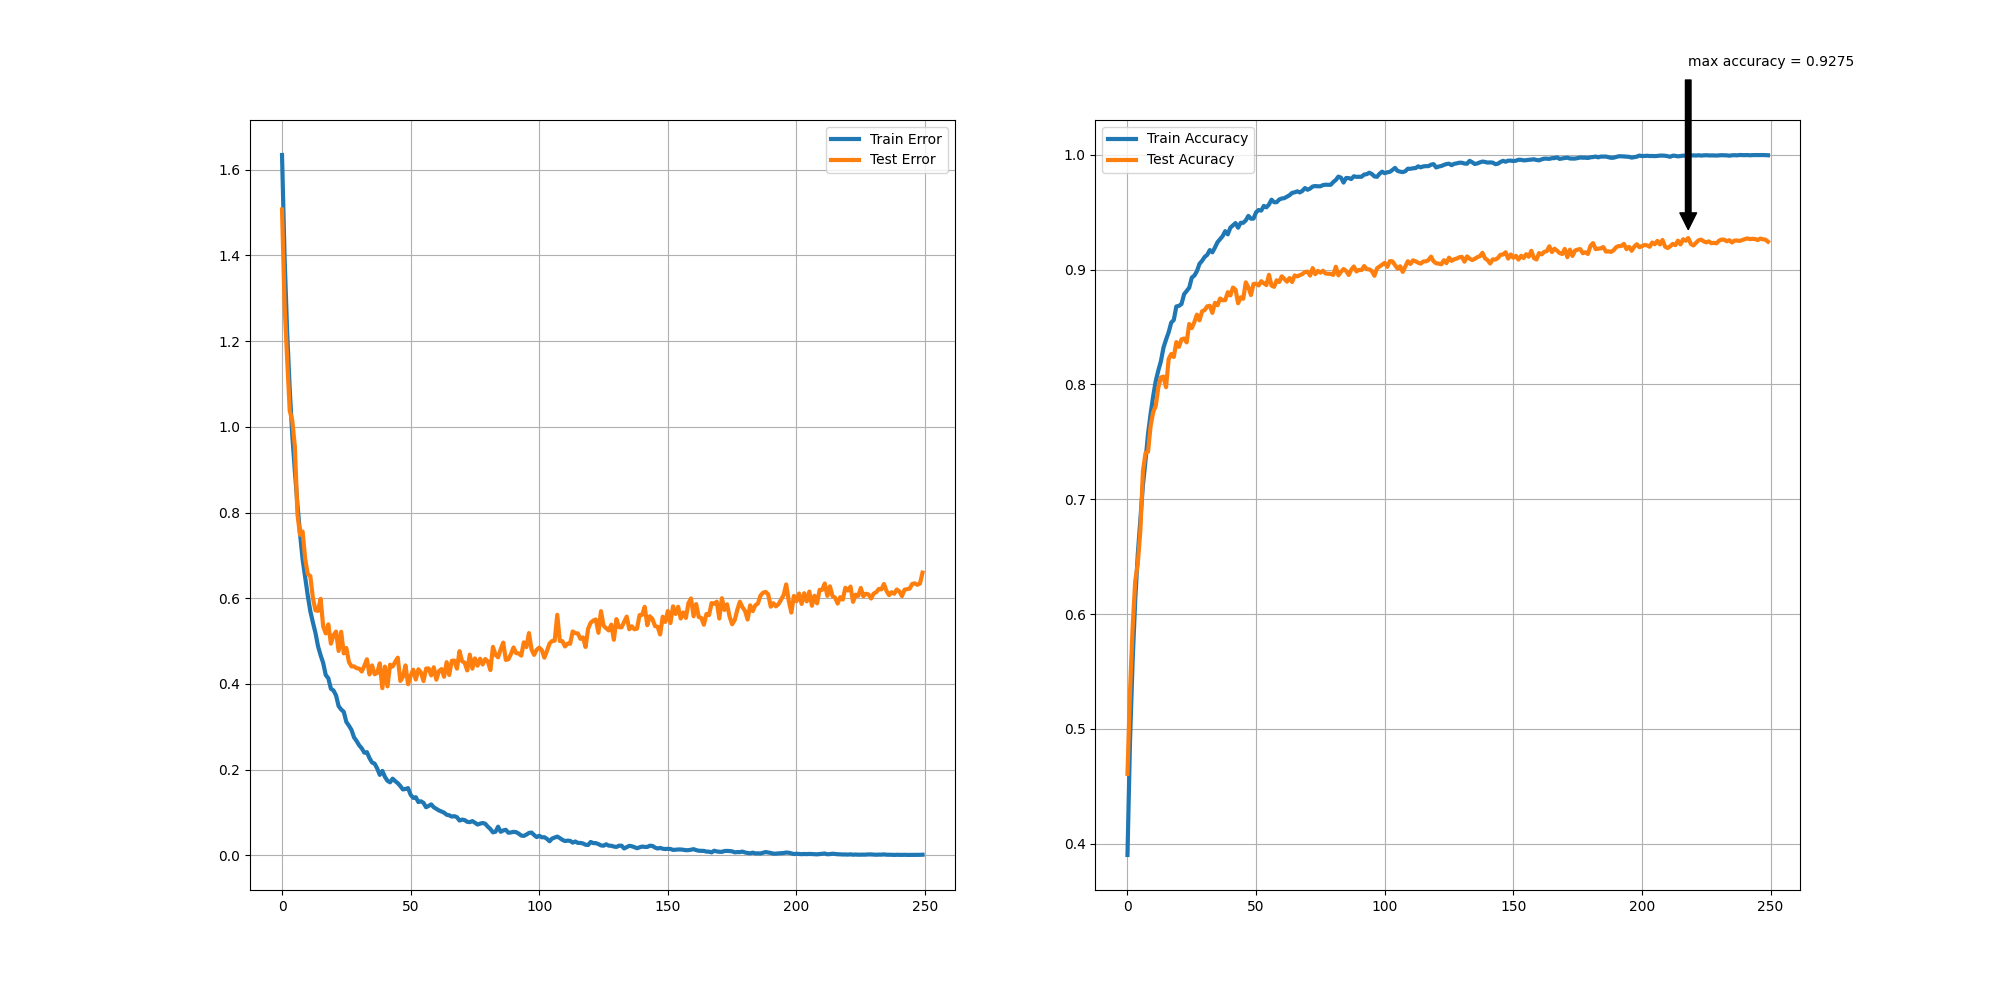